# predicting health coverage in the US

This project will call data from the American Community Survey Public Use MicroSample(PUMS) API. The most recent survey publicly availble at this API is from 2019. (Note data from 2020 are available to download in csv files).

This project uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.

1. American Community Survey (ACS) (census.gov).
https://www.census.gov/programs-surveys/acs/
2. American Community Survey Data via API (census.gov).
https://www.census.gov/programs-surveys/acs/data/data-via-api.html

The goal of this project is to predict whether an individual has health insurance (or not) based on demographic data in the PUMS. 

In [1]:
# import libraries
import os
import glob
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
import numpy as np
from dotenv import load_dotenv
from statsmodels.graphics.mosaicplot import mosaic
import utils

Load the cleaned data and the code dictionary for the column names.

In [2]:
datadir = os.path.join(os.getcwd(),"raw_data")
interimdatadir = os.path.join(os.getcwd(),"interim_data")
figdir = os.path.join(os.getcwd(),"plots")

In [3]:
_,_,_,nsamples=utils.getVars()

df_fname = os.path.join(interimdatadir,'allstates_subsample' + str(nsamples) + '_defvars_df.pkl')
df = pd.read_pickle(df_fname)

fname    = os.path.join(interimdatadir,str(nsamples) + 'targets_oi.csv')
targ_oi  = pd.read_csv(fname)

codedict,_ = utils.getCodeDictionary()
target   = targ_oi['healthcodes'][1]

print('our target variable is ' + codedict[target])
print('currently there are ' + str(df.shape[1]-1) + ' predictors in the dataset.')

our target variable is private health insurance coverage recode
currently there are 279 predictors in the dataset.


In [4]:
df.head()

,HHLANP,FBATHP,DRIVESP,FWATP,FBROADBNDP,FWKWNP,HOTWAT,FWKHP,FFULP,FJWDP,...,SOCP,FSMOCP,FDOUTP,PERNP,SCH,WKL,TEL,TEN,BST,STATE
0,9500,0,0,0,0,0,9,0,0,0,...,472031,0,0,1200,1,1,1,3,1,AL
1,9500,0,1,0,0,0,9,0,0,0,...,1910XX,0,0,40700,1,1,1,1,1,AL
2,9500,0,0,0,0,0,9,0,0,0,...,-1,0,0,-10001,2,0,1,1,1,AL
3,9500,0,0,0,0,0,9,0,0,0,...,-1,0,0,0,1,3,1,3,1,AL
4,9500,1,0,1,0,0,9,0,1,0,...,533030,1,1,0,1,2,1,1,1,AL


We know that there are a number of categorical variables in the dataset, as well as numerical variables. We can use the predictive power score (pps) to estimate the predictive power of each variable for our target variable. However, to use the predictive power score, we need to convert categorical variables to data type 'category.' 

In [5]:
# use predictive power score to see if there's a relationship between our target variable and other columns
predictors_df = pps.predictors(df, y=target,sorted=True)
predictors_df.set_index('x',inplace=True)
predictors_df.head(10)

,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
x,,,,,,,,
OTHSVCEX,PRIVCOV,0.220668,classification,True,weighted F1,0.5908,0.681097,DecisionTreeClassifier()
DIS,PRIVCOV,0.215905,classification,True,weighted F1,0.5908,0.679148,DecisionTreeClassifier()
POVPIP,PRIVCOV,0.206243,classification,True,weighted F1,0.5908,0.675195,DecisionTreeClassifier()
HINCP,PRIVCOV,0.197570,classification,True,weighted F1,0.5908,0.671646,DecisionTreeClassifier()
FS,PRIVCOV,0.175970,classification,True,weighted F1,0.5908,0.662807,DecisionTreeClassifier()
DOUT,PRIVCOV,0.146194,classification,True,weighted F1,0.5908,0.650623,DecisionTreeClassifier()
HHLANP,PRIVCOV,0.142606,classification,True,weighted F1,0.5908,0.649154,DecisionTreeClassifier()
WORKSTAT,PRIVCOV,0.142452,classification,True,weighted F1,0.5908,0.649091,DecisionTreeClassifier()
PINCP,PRIVCOV,0.140409,classification,True,weighted F1,0.5908,0.648255,DecisionTreeClassifier()


In [6]:
def ecdf(x):
    y = list()
    for i in x:
        y.append(sum(x <= i)/len(x))
    return x,y

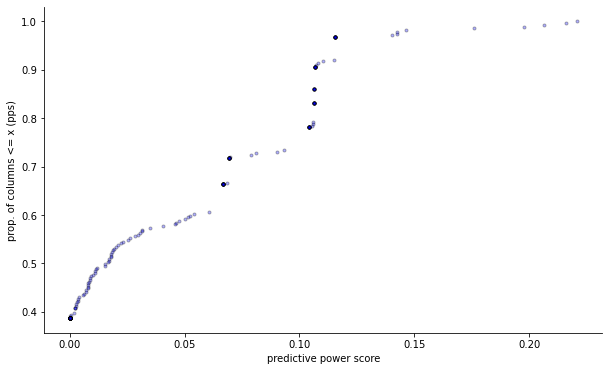

In [7]:
fig,ax=plt.subplots(figsize=(10,6))

x,y=ecdf(predictors_df['ppscore'])
ax.plot(x,y,marker='.',linestyle='None',color='None',markerfacecolor='blue',alpha=0.3)
sns.despine()
sns.color_palette('hls',8)
ax.set_xlabel('predictive power score')
ax.set_ylabel('prop. of columns <= x (pps)')
plt.show()

In [8]:
# we can first just set a low threshold to get rid of columns with very low pps
pps_0 = predictors_df[predictors_df['ppscore'] == 0].index
predictors_df = predictors_df.drop(index=pps_0,axis=0)
df = df.drop(pps_0,axis=1)

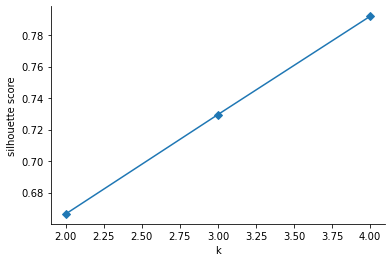

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pps = predictors_df[['ppscore']]
ks = [2,3,4]
silh_score = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pps)
    silh_score.append(silhouette_score(pps,kmeans.predict(pps)))
plt.plot(ks,silh_score,marker='D')
plt.xlabel("k")
plt.ylabel('silhouette score')
sns.despine()
plt.show()

In [10]:
k_best = ks[silh_score.index(max(silh_score))]
kmeans = KMeans(n_clusters=k_best)
kmeans.fit(pps)
clust = kmeans.labels_

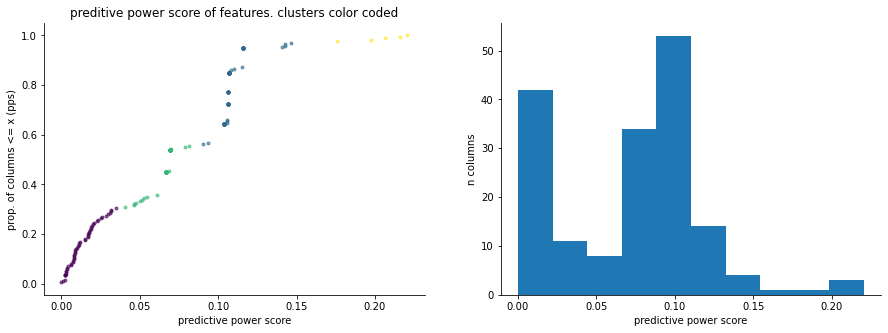

In [11]:
from matplotlib import cm
cmap=cm.get_cmap('viridis', k_best)
colors = cmap.colors

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
x,y=ecdf(predictors_df['ppscore'])
for i in range(len(x)):
    ax[0].plot(x[i],y[i],marker='.',linestyle='None',color=colors[clust[i]],markerfacecolor=colors[clust[i]],alpha=0.6)
sns.despine()
ax[0].set_xlabel('predictive power score')
ax[0].set_ylabel('prop. of columns <= x (pps)')
ax[0].set_title('preditive power score of features. clusters color coded')
ax[1].hist(predictors_df['ppscore'])
ax[1].set_xlabel('predictive power score')
ax[1].set_ylabel('n columns')
plt.show()

figname = os.path.join(figdir,'predictivepowerscore_cumulativedist.png')
fig.savefig(figname,dpi=None,orientation='portrait', transparent=True,bbox_inches='tight')

In [12]:
# check which cluster corresponds to higher pps
predictors_df['clust'] = clust
srtdf = predictors_df.groupby('clust').max().sort_values('ppscore',ascending=True)
srtdf

C:\Users\kacie\AppData\Local\Temp\ipykernel_16996\4274867971.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  srtdf = predictors_df.groupby('clust').max().sort_values('ppscore',ascending=True)


,y,ppscore,case,is_valid_score,metric,baseline_score,model_score
clust,,,,,,,
0,PRIVCOV,0.034781,classification,True,weighted F1,0.5908,0.605032
2,PRIVCOV,0.081256,classification,True,weighted F1,0.5908,0.624050
1,PRIVCOV,0.146194,classification,True,weighted F1,0.5908,0.650623
3,PRIVCOV,0.220668,classification,True,weighted F1,0.5908,0.681097


In [13]:
# drop bottom two clusters:
bottom_bound = srtdf['ppscore'].iloc[1]
pps_0 = predictors_df['ppscore'][predictors_df.ppscore <= bottom_bound].index
predictors_df = predictors_df.drop(index=pps_0,axis=1)
df = df.drop(pps_0,axis=1)

In [14]:
#what kind of variables are left? 
df.dtypes.astype('str').value_counts()

category    71
int64        6
dtype: int64

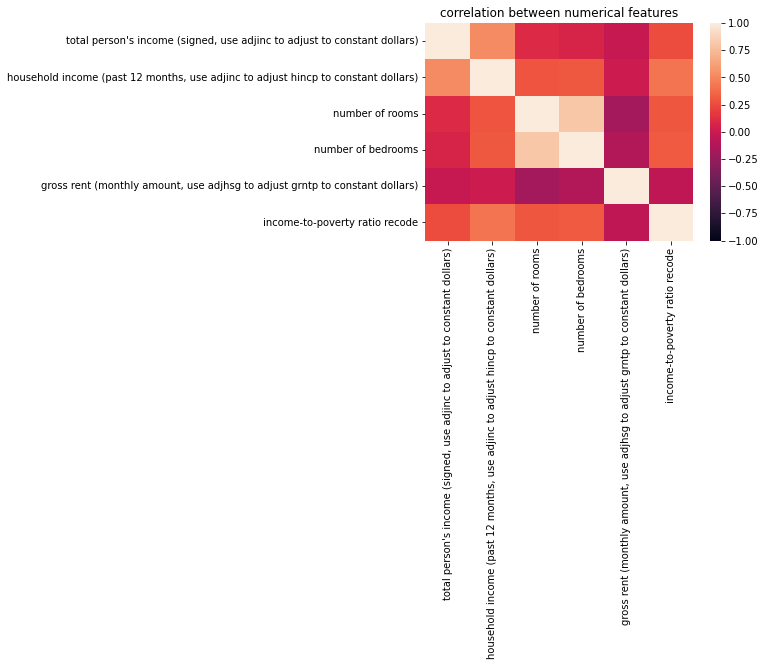

In [16]:
# correlation among numerical variables
numdf = df.select_dtypes('int')
for column in numdf:
    numdf = numdf.rename(columns={column:codedict[column]})
sns.heatmap(numdf.corr(),vmin=-1,vmax=1)
plt.title('correlation between numerical features')
plt.show()       

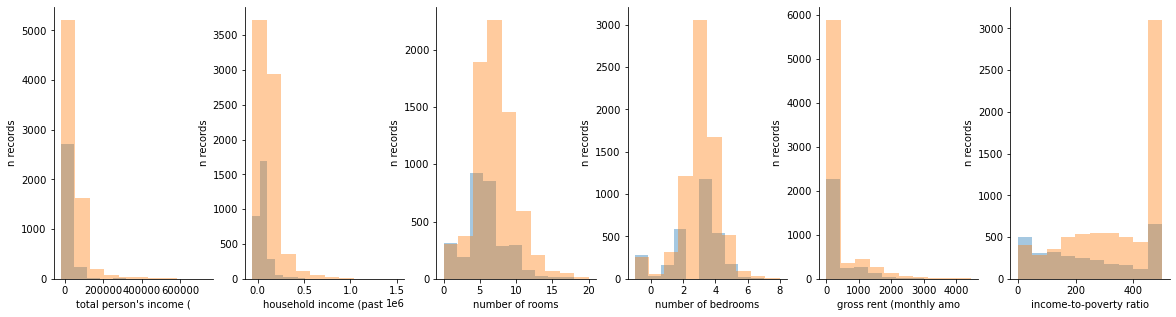

In [77]:
numdf[codedict[target]] = df[target]
fig,ax = plt.subplots(nrows=1,ncols=numdf.shape[1]-1,figsize=(20,5))
cnt = 0
for column in numdf:
    if column == codedict[target]:
        continue
    else:
        numdf.groupby(codedict[target])[column].hist(ax=ax[cnt],alpha=0.4)
        sns.despine()
        ax[cnt].set_xlabel(column[0:23])
        ax[cnt].set_ylabel('n records')
        ax[cnt].grid(False)
        cnt += 1

In [45]:
catcols = df.select_dtypes('category').columns

Index(['HHLANP', 'FBATHP', 'FWATP', 'FBROADBNDP', 'HOTWAT', 'FFULP',
       'WORKSTAT', 'STOV', 'FMHP', 'SRNT', 'DOUT', 'FACCESSP', 'OTHSVCEX',
       'PRIVCOV', 'HUPAC', 'FBLDP', 'DIS', 'FINSP', 'FBDSP', 'FRNTMP',
       'FOTHSVCEXP', 'LAPTOP', 'FMRGIP', 'FCOMPOTHXP', 'FS', 'FACRP', 'FSTOVP',
       'FTELP', 'RWAT', 'FPLMPRP', 'FTENP', 'BLD', 'FVEHP', 'GASFP', 'WATFP',
       'FGASP', 'RESMODE', 'REFR', 'FPLMP', 'ELEFP', 'RELSHIPP', 'RC',
       'FHISPEEDP', 'FKITP', 'YBL', 'FFINCP', 'FSMXHP', 'FTABLETP', 'FGRNTP',
       'FVACSP', 'FHOTWATP', 'PSF', 'FSMARTPHONP', 'SINK', 'KIT', 'FVALP',
       'NPP', 'FRWATPRP', 'HUGCL', 'FMRGXP', 'FULFP', 'BATH', 'COMPOTHX',
       'FSINKP', 'FHFLP', 'FSMXSP', 'PLMPRP', 'ACCESS', 'FSMOCP', 'TEL',
       'TEN'],
      dtype='object')


In [64]:
predictors_df = predictors_df.reset_index()

In [79]:
cat_pred = predictors_df[predictors_df['x'].isin(catcols)]
cat_pred = cat_pred.sort_values('ppscore',ascending=False)

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model,clust
0,OTHSVCEX,PRIVCOV,0.220668,classification,True,weighted F1,0.5908,0.681097,DecisionTreeClassifier(),3
1,DIS,PRIVCOV,0.215905,classification,True,weighted F1,0.5908,0.679148,DecisionTreeClassifier(),3
4,FS,PRIVCOV,0.175970,classification,True,weighted F1,0.5908,0.662807,DecisionTreeClassifier(),3
5,DOUT,PRIVCOV,0.146194,classification,True,weighted F1,0.5908,0.650623,DecisionTreeClassifier(),1
6,HHLANP,PRIVCOV,0.142606,classification,True,weighted F1,0.5908,0.649154,DecisionTreeClassifier(),1
...,...,...,...,...,...,...,...,...,...,...
70,HUGCL,PRIVCOV,0.103994,classification,True,weighted F1,0.5908,0.633355,DecisionTreeClassifier(),1
71,FMRGXP,PRIVCOV,0.103994,classification,True,weighted F1,0.5908,0.633355,DecisionTreeClassifier(),1
72,FULFP,PRIVCOV,0.103994,classification,True,weighted F1,0.5908,0.633355,DecisionTreeClassifier(),1
73,BATH,PRIVCOV,0.103994,classification,True,weighted F1,0.5908,0.633355,DecisionTreeClassifier(),1


In [101]:
top_scores = 10
plot_cols = cat_pred['x'][:top_scores]

In [108]:
#labelizer=lambda k:{('Male','Yes'):357,('Female','Yes'):31,('Male','No'):130,('Female','No'):80}[k]
for column in plot_cols:
    crosstable = pd.crosstab(df[target],df[column])
    mosaic(df['target'],df[column])
    plt.show()

KeyError: 'target'

In [18]:
# save new data frames
new_df_fname = os.path.join(interimdatadir,'allstates_subsample' + str(nsamples) + '_eda_df.pkl')
df.to_pickle(new_df_fname)

preddf_fname = os.path.join(interimdatadir,'allstates_subsample' + str(nsamples) + '_eda_preddf.pkl')
predictors_df.to_pickle(preddf_fname)